<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO)
---
In this notebook, you will implement a PPO agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium gymnasium[box2d]

In [3]:
import gymnasium
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.vec_env import VecVideoRecorder

import os
import torch
import numpy
import scipy
import platform
import IPython
import matplotlib
import matplotlib.pyplot

In [4]:
print("Python Version: {}".format(platform.python_version()))
print("Is Cuda Available: {}".format(torch.cuda.is_available()))
print("Torch Version: {}".format(torch.__version__))
print("Cuda Version: {}".format(torch.version.cuda))
print("Scipy Version: {}".format(scipy.__version__))
print("Numpy Version: {}".format(numpy.__version__))
print("Stable Baseline Version: {}".format(stable_baselines3.__version__))
print("IPython Version: {}".format(IPython.__version__))
print("Gymnasium Version: {}".format(gymnasium.__version__))

Python Version: 3.10.12
Is Cuda Available: True
Torch Version: 2.3.1+cu121
Cuda Version: 12.1
Scipy Version: 1.13.1
Numpy Version: 1.26.4
Stable Baseline Version: 2.3.2
IPython Version: 7.34.0
Gymnasium Version: 0.29.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gymnasium.make('LunarLander-v2')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  ()


In [ ]:
env_str = "LunarLander-v2"
log_dir = "./logs/{}".format(env_str)

In [ ]:
#Create Training Environment
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=2000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500000,  progress_bar=True, callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_lunar_lander"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501,747/500,000  [ 1:35:29 < 0:00:00 , 140 it/s ]

Mean reward: 255.46 +/- 42.45


In [ ]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model - Mean reward: 266.01 +/- 34.38
Moviepy - Building video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


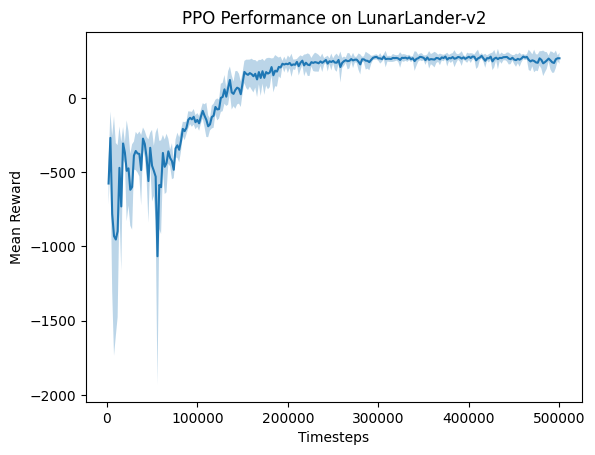

In [ ]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('PPO Performance on LunarLander-v2')
matplotlib.pyplot.show()

In [5]:
env = gymnasium.make('LunarLanderContinuous-v2')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  (2,)


In [6]:
env_str = "LunarLanderContinuous-v2"
log_dir = "./logs/{}".format(env_str)

In [7]:
#Create Training Environment)
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=2000,
                             render=False,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500000,  progress_bar=True, callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_lunar_lander"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=2000, episode_reward=-95.36 +/- 73.21

Episode length: 77.80 +/- 12.16

New best mean reward!

Eval num_timesteps=4000, episode_reward=-240.86 +/- 90.20

Episode length: 108.55 +/- 18.61

Eval num_timesteps=6000, episode_reward=-114.26 +/- 73.72

Episode length: 78.15 +/- 13.51

Eval num_timesteps=8000, episode_reward=-105.36 +/- 83.61

Episode length: 127.55 +/- 200.53

Eval num_timesteps=10000, episode_reward=-127.25 +/- 119.57

Episode length: 97.00 +/- 15.71

Eval num_timesteps=12000, episode_reward=-150.45 +/- 106.06

Episode length: 107.70 +/- 16.69

Eval num_timesteps=14000, episode_reward=-160.55 +/- 114.89

Episode length: 122.25 +/- 18.22

Eval num_timesteps=16000, episode_reward=-180.27 +/- 145.31

Episode length: 142.10 +/- 63.46

Eval num_timesteps=18000, episode_reward=-228.34 +/- 58.80

Episode length: 141.70 +/- 67.05

Eval num_timesteps=20000, episode_reward=-185.86 +/- 83.17

Episode length: 189.60 +/- 168.85

Eval num_timesteps=22000, episode_reward=-172.12 +/- 80.88

Episode length: 198.65 +/- 191.01

Eval num_timesteps=24000, episode_reward=-165.28 +/- 30.19

Episode length: 155.55 +/- 45.19

Eval num_timesteps=26000, episode_reward=-157.73 +/- 41.31

Episode length: 260.65 +/- 182.70

Eval num_timesteps=28000, episode_reward=-233.91 +/- 86.36

Episode length: 382.70 +/- 303.68

Eval num_timesteps=30000, episode_reward=-109.48 +/- 132.53

Episode length: 341.95 +/- 192.39

Eval num_timesteps=32000, episode_reward=-107.90 +/- 126.05

Episode length: 347.65 +/- 254.59

Eval num_timesteps=34000, episode_reward=38.08 +/- 154.97

Episode length: 422.10 +/- 155.11

New best mean reward!

Eval num_timesteps=36000, episode_reward=84.66 +/- 156.06

Episode length: 472.00 +/- 135.15

New best mean reward!

Eval num_timesteps=38000, episode_reward=33.00 +/- 149.96

Episode length: 517.95 +/- 173.56

Eval num_timesteps=40000, episode_reward=-30.08 +/- 151.14

Episode length: 483.40 +/- 154.73

Eval num_timesteps=42000, episode_reward=-153.82 +/- 89.56

Episode length: 445.75 +/- 210.37

Eval num_timesteps=44000, episode_reward=-56.31 +/- 130.64

Episode length: 435.80 +/- 223.85

Eval num_timesteps=46000, episode_reward=-74.89 +/- 137.71

Episode length: 603.65 +/- 228.78

Eval num_timesteps=48000, episode_reward=-271.27 +/- 156.10

Episode length: 615.35 +/- 269.78

Eval num_timesteps=50000, episode_reward=-310.34 +/- 148.79

Episode length: 607.60 +/- 286.19

Eval num_timesteps=52000, episode_reward=-204.73 +/- 44.27

Episode length: 492.10 +/- 192.56

Eval num_timesteps=54000, episode_reward=-147.31 +/- 97.51

Episode length: 548.80 +/- 198.72

Eval num_timesteps=56000, episode_reward=-91.35 +/- 120.13

Episode length: 409.70 +/- 223.84

Eval num_timesteps=58000, episode_reward=-20.38 +/- 135.90

Episode length: 542.70 +/- 241.80

Eval num_timesteps=60000, episode_reward=-25.55 +/- 151.12

Episode length: 580.65 +/- 214.34

Eval num_timesteps=62000, episode_reward=44.34 +/- 131.77

Episode length: 800.60 +/- 118.28

Eval num_timesteps=64000, episode_reward=-81.48 +/- 103.48

Episode length: 900.75 +/- 151.05

Eval num_timesteps=66000, episode_reward=-18.13 +/- 135.73

Episode length: 809.60 +/- 184.33

Eval num_timesteps=68000, episode_reward=-36.30 +/- 126.44

Episode length: 844.35 +/- 165.66

Eval num_timesteps=70000, episode_reward=-41.25 +/- 137.45

Episode length: 739.75 +/- 241.53

Eval num_timesteps=72000, episode_reward=-16.40 +/- 136.98

Episode length: 767.25 +/- 196.07

Eval num_timesteps=74000, episode_reward=-60.60 +/- 138.76

Episode length: 785.55 +/- 192.87

Eval num_timesteps=76000, episode_reward=-83.15 +/- 108.37

Episode length: 732.35 +/- 235.48

Eval num_timesteps=78000, episode_reward=-115.64 +/- 86.16

Episode length: 862.60 +/- 199.07

Eval num_timesteps=80000, episode_reward=-5.61 +/- 106.69

Episode length: 911.45 +/- 115.63

Eval num_timesteps=82000, episode_reward=11.25 +/- 102.48

Episode length: 911.95 +/- 133.47

Eval num_timesteps=84000, episode_reward=73.03 +/- 103.88

Episode length: 808.05 +/- 131.75

Eval num_timesteps=86000, episode_reward=64.19 +/- 91.95

Episode length: 895.60 +/- 120.02

Eval num_timesteps=88000, episode_reward=43.75 +/- 139.53

Episode length: 732.30 +/- 171.92

Eval num_timesteps=90000, episode_reward=83.27 +/- 113.42

Episode length: 842.00 +/- 173.66

Eval num_timesteps=92000, episode_reward=139.25 +/- 64.09

Episode length: 807.85 +/- 137.68

New best mean reward!

Eval num_timesteps=94000, episode_reward=146.21 +/- 66.82

Episode length: 748.90 +/- 140.03

New best mean reward!

Eval num_timesteps=96000, episode_reward=162.68 +/- 95.64

Episode length: 645.30 +/- 140.39

New best mean reward!

Eval num_timesteps=98000, episode_reward=90.22 +/- 128.67

Episode length: 717.25 +/- 193.34

Eval num_timesteps=100000, episode_reward=12.60 +/- 129.97

Episode length: 728.10 +/- 197.19

Eval num_timesteps=102000, episode_reward=44.61 +/- 130.79

Episode length: 688.45 +/- 173.20

Eval num_timesteps=104000, episode_reward=94.72 +/- 108.89

Episode length: 718.45 +/- 197.54

Eval num_timesteps=106000, episode_reward=124.10 +/- 97.62

Episode length: 653.90 +/- 116.10

Eval num_timesteps=108000, episode_reward=122.31 +/- 106.49

Episode length: 625.25 +/- 107.32

Eval num_timesteps=110000, episode_reward=143.55 +/- 94.14

Episode length: 582.40 +/- 107.01

Eval num_timesteps=112000, episode_reward=154.23 +/- 89.24

Episode length: 542.75 +/- 76.86

Eval num_timesteps=114000, episode_reward=157.02 +/- 81.43

Episode length: 574.60 +/- 97.64

Eval num_timesteps=116000, episode_reward=170.43 +/- 85.65

Episode length: 533.90 +/- 80.96

New best mean reward!

Eval num_timesteps=118000, episode_reward=161.24 +/- 92.75

Episode length: 564.45 +/- 89.23

Eval num_timesteps=120000, episode_reward=162.51 +/- 83.01

Episode length: 598.45 +/- 118.70

Eval num_timesteps=122000, episode_reward=111.39 +/- 125.16

Episode length: 628.35 +/- 147.53

Eval num_timesteps=124000, episode_reward=168.33 +/- 59.83

Episode length: 645.80 +/- 107.04

Eval num_timesteps=126000, episode_reward=97.75 +/- 111.82

Episode length: 651.25 +/- 130.02

Eval num_timesteps=128000, episode_reward=153.99 +/- 80.79

Episode length: 550.35 +/- 70.49

Eval num_timesteps=130000, episode_reward=161.38 +/- 68.48

Episode length: 572.00 +/- 93.96

Eval num_timesteps=132000, episode_reward=151.16 +/- 95.60

Episode length: 593.75 +/- 80.30

Eval num_timesteps=134000, episode_reward=156.50 +/- 54.73

Episode length: 615.15 +/- 125.53

Eval num_timesteps=136000, episode_reward=161.22 +/- 80.60

Episode length: 607.85 +/- 146.92

Eval num_timesteps=138000, episode_reward=135.08 +/- 87.54

Episode length: 695.05 +/- 178.07

Eval num_timesteps=140000, episode_reward=114.49 +/- 123.93

Episode length: 667.75 +/- 163.71

Eval num_timesteps=142000, episode_reward=132.43 +/- 110.41

Episode length: 649.05 +/- 189.36

Eval num_timesteps=144000, episode_reward=169.65 +/- 89.20

Episode length: 573.05 +/- 151.28

Eval num_timesteps=146000, episode_reward=83.79 +/- 142.67

Episode length: 673.70 +/- 177.71

Eval num_timesteps=148000, episode_reward=97.06 +/- 144.16

Episode length: 631.80 +/- 199.01

Eval num_timesteps=150000, episode_reward=95.30 +/- 121.63

Episode length: 630.10 +/- 209.61

Eval num_timesteps=152000, episode_reward=48.46 +/- 147.35

Episode length: 635.25 +/- 222.22

Eval num_timesteps=154000, episode_reward=46.05 +/- 136.90

Episode length: 627.05 +/- 210.17

Eval num_timesteps=156000, episode_reward=107.62 +/- 123.58

Episode length: 513.10 +/- 144.46

Eval num_timesteps=158000, episode_reward=146.12 +/- 99.69

Episode length: 599.10 +/- 147.36

Eval num_timesteps=160000, episode_reward=52.69 +/- 135.59

Episode length: 605.85 +/- 161.26

Eval num_timesteps=162000, episode_reward=102.54 +/- 143.02

Episode length: 562.30 +/- 138.56

Eval num_timesteps=164000, episode_reward=160.18 +/- 81.92

Episode length: 502.10 +/- 105.99

Eval num_timesteps=166000, episode_reward=131.15 +/- 112.35

Episode length: 436.95 +/- 69.41

Eval num_timesteps=168000, episode_reward=160.83 +/- 95.99

Episode length: 423.35 +/- 75.99

Eval num_timesteps=170000, episode_reward=134.05 +/- 114.64

Episode length: 420.70 +/- 88.81

Eval num_timesteps=172000, episode_reward=132.33 +/- 107.01

Episode length: 421.75 +/- 93.20

Eval num_timesteps=174000, episode_reward=198.94 +/- 63.17

Episode length: 427.20 +/- 52.02

New best mean reward!

Eval num_timesteps=176000, episode_reward=179.04 +/- 83.58

Episode length: 414.60 +/- 83.43

Eval num_timesteps=178000, episode_reward=169.26 +/- 91.03

Episode length: 386.05 +/- 48.08

Eval num_timesteps=180000, episode_reward=173.31 +/- 86.05

Episode length: 375.15 +/- 36.26

Eval num_timesteps=182000, episode_reward=146.96 +/- 110.64

Episode length: 387.60 +/- 76.10

Eval num_timesteps=184000, episode_reward=121.28 +/- 122.71

Episode length: 365.95 +/- 44.98

Eval num_timesteps=186000, episode_reward=179.78 +/- 68.06

Episode length: 422.10 +/- 99.80

Eval num_timesteps=188000, episode_reward=183.32 +/- 79.33

Episode length: 384.40 +/- 43.86

Eval num_timesteps=190000, episode_reward=162.12 +/- 103.23

Episode length: 389.55 +/- 86.48

Eval num_timesteps=192000, episode_reward=166.45 +/- 105.54

Episode length: 390.05 +/- 78.16

Eval num_timesteps=194000, episode_reward=138.60 +/- 109.61

Episode length: 375.40 +/- 72.63

Eval num_timesteps=196000, episode_reward=157.29 +/- 100.86

Episode length: 378.00 +/- 39.28

Eval num_timesteps=198000, episode_reward=174.19 +/- 96.61

Episode length: 360.95 +/- 39.61

Eval num_timesteps=200000, episode_reward=149.90 +/- 111.64

Episode length: 357.80 +/- 41.09

Eval num_timesteps=202000, episode_reward=125.56 +/- 112.18

Episode length: 364.20 +/- 49.15

Eval num_timesteps=204000, episode_reward=168.33 +/- 82.73

Episode length: 406.65 +/- 94.54

Eval num_timesteps=206000, episode_reward=121.52 +/- 114.20

Episode length: 344.20 +/- 70.23

Eval num_timesteps=208000, episode_reward=48.95 +/- 123.81

Episode length: 325.90 +/- 52.86

Eval num_timesteps=210000, episode_reward=7.19 +/- 114.40

Episode length: 318.65 +/- 51.51

Eval num_timesteps=212000, episode_reward=82.98 +/- 129.71

Episode length: 352.85 +/- 82.38

Eval num_timesteps=214000, episode_reward=120.75 +/- 118.44

Episode length: 349.60 +/- 55.74

Eval num_timesteps=216000, episode_reward=120.06 +/- 123.38

Episode length: 363.60 +/- 81.14

Eval num_timesteps=218000, episode_reward=137.74 +/- 108.09

Episode length: 354.20 +/- 47.47

Eval num_timesteps=220000, episode_reward=129.51 +/- 111.86

Episode length: 363.55 +/- 66.51

Eval num_timesteps=222000, episode_reward=110.22 +/- 120.91

Episode length: 361.15 +/- 46.10

Eval num_timesteps=224000, episode_reward=122.18 +/- 113.31

Episode length: 355.40 +/- 71.80

Eval num_timesteps=226000, episode_reward=147.65 +/- 113.02

Episode length: 358.20 +/- 31.45

Eval num_timesteps=228000, episode_reward=146.62 +/- 97.44

Episode length: 397.70 +/- 146.75

Eval num_timesteps=230000, episode_reward=111.56 +/- 117.77

Episode length: 343.10 +/- 48.54

Eval num_timesteps=232000, episode_reward=132.83 +/- 118.75

Episode length: 364.20 +/- 36.43

Eval num_timesteps=234000, episode_reward=128.84 +/- 112.37

Episode length: 383.70 +/- 63.65

Eval num_timesteps=236000, episode_reward=167.79 +/- 83.22

Episode length: 378.60 +/- 39.70

Eval num_timesteps=238000, episode_reward=127.15 +/- 117.21

Episode length: 371.10 +/- 66.04

Eval num_timesteps=240000, episode_reward=129.17 +/- 113.89

Episode length: 375.60 +/- 147.05

Eval num_timesteps=242000, episode_reward=121.17 +/- 109.85

Episode length: 338.05 +/- 44.12

Eval num_timesteps=244000, episode_reward=199.11 +/- 53.60

Episode length: 407.45 +/- 123.35

New best mean reward!

Eval num_timesteps=246000, episode_reward=184.70 +/- 68.58

Episode length: 376.40 +/- 37.28

Eval num_timesteps=248000, episode_reward=130.99 +/- 121.81

Episode length: 361.70 +/- 82.69

Eval num_timesteps=250000, episode_reward=115.12 +/- 123.77

Episode length: 349.60 +/- 58.06

Eval num_timesteps=252000, episode_reward=168.19 +/- 101.28

Episode length: 370.30 +/- 64.06

Eval num_timesteps=254000, episode_reward=171.14 +/- 103.85

Episode length: 360.80 +/- 33.39

Eval num_timesteps=256000, episode_reward=178.96 +/- 97.18

Episode length: 363.10 +/- 46.76

Eval num_timesteps=258000, episode_reward=147.30 +/- 121.63

Episode length: 396.40 +/- 148.10

Eval num_timesteps=260000, episode_reward=143.13 +/- 113.46

Episode length: 353.95 +/- 53.42

Eval num_timesteps=262000, episode_reward=96.65 +/- 146.84

Episode length: 338.75 +/- 29.12

Eval num_timesteps=264000, episode_reward=123.40 +/- 156.41

Episode length: 336.00 +/- 45.66

Eval num_timesteps=266000, episode_reward=155.43 +/- 104.76

Episode length: 346.25 +/- 54.61

Eval num_timesteps=268000, episode_reward=143.29 +/- 111.36

Episode length: 350.90 +/- 104.32

Eval num_timesteps=270000, episode_reward=118.12 +/- 126.62

Episode length: 349.75 +/- 100.15

Eval num_timesteps=272000, episode_reward=171.07 +/- 104.54

Episode length: 340.45 +/- 42.49

Eval num_timesteps=274000, episode_reward=137.86 +/- 110.01

Episode length: 338.30 +/- 45.47

Eval num_timesteps=276000, episode_reward=93.51 +/- 109.77

Episode length: 352.25 +/- 90.19

Eval num_timesteps=278000, episode_reward=156.00 +/- 105.26

Episode length: 341.90 +/- 40.81

Eval num_timesteps=280000, episode_reward=162.03 +/- 110.00

Episode length: 368.55 +/- 60.87

Eval num_timesteps=282000, episode_reward=172.66 +/- 92.79

Episode length: 393.85 +/- 105.12

Eval num_timesteps=284000, episode_reward=122.17 +/- 118.35

Episode length: 366.40 +/- 82.76

Eval num_timesteps=286000, episode_reward=135.75 +/- 111.77

Episode length: 341.45 +/- 45.70

Eval num_timesteps=288000, episode_reward=165.82 +/- 98.81

Episode length: 367.40 +/- 37.93

Eval num_timesteps=290000, episode_reward=161.40 +/- 107.01

Episode length: 345.55 +/- 42.20

Eval num_timesteps=292000, episode_reward=169.03 +/- 95.50

Episode length: 397.70 +/- 109.25

Eval num_timesteps=294000, episode_reward=112.97 +/- 121.38

Episode length: 347.05 +/- 67.58

Eval num_timesteps=296000, episode_reward=168.59 +/- 112.59

Episode length: 327.90 +/- 42.31

Eval num_timesteps=298000, episode_reward=137.04 +/- 125.12

Episode length: 329.25 +/- 41.18

Eval num_timesteps=300000, episode_reward=135.03 +/- 111.59

Episode length: 323.90 +/- 71.20

Eval num_timesteps=302000, episode_reward=193.97 +/- 93.12

Episode length: 342.65 +/- 61.33

Eval num_timesteps=304000, episode_reward=151.76 +/- 114.28

Episode length: 340.55 +/- 39.86

Eval num_timesteps=306000, episode_reward=156.88 +/- 109.86

Episode length: 338.55 +/- 61.34

Eval num_timesteps=308000, episode_reward=158.10 +/- 110.94

Episode length: 335.45 +/- 38.84

Eval num_timesteps=310000, episode_reward=165.03 +/- 100.97

Episode length: 339.75 +/- 49.95

Eval num_timesteps=312000, episode_reward=163.09 +/- 106.74

Episode length: 378.50 +/- 116.47

Eval num_timesteps=314000, episode_reward=162.95 +/- 105.21

Episode length: 355.35 +/- 39.47

Eval num_timesteps=316000, episode_reward=171.43 +/- 101.67

Episode length: 366.70 +/- 48.04

Eval num_timesteps=318000, episode_reward=183.00 +/- 81.15

Episode length: 418.95 +/- 118.65

Eval num_timesteps=320000, episode_reward=176.54 +/- 98.90

Episode length: 396.90 +/- 78.42

Eval num_timesteps=322000, episode_reward=150.63 +/- 101.16

Episode length: 381.65 +/- 43.51

Eval num_timesteps=324000, episode_reward=159.57 +/- 106.12

Episode length: 406.15 +/- 80.39

Eval num_timesteps=326000, episode_reward=177.97 +/- 94.88

Episode length: 420.75 +/- 75.78

Eval num_timesteps=328000, episode_reward=199.76 +/- 75.20

Episode length: 395.40 +/- 36.22

New best mean reward!

Eval num_timesteps=330000, episode_reward=165.44 +/- 113.68

Episode length: 406.40 +/- 87.45

Eval num_timesteps=332000, episode_reward=182.84 +/- 96.35

Episode length: 403.40 +/- 59.86

Eval num_timesteps=334000, episode_reward=135.45 +/- 110.57

Episode length: 408.80 +/- 90.21

Eval num_timesteps=336000, episode_reward=174.74 +/- 90.01

Episode length: 437.05 +/- 149.78

Eval num_timesteps=338000, episode_reward=126.06 +/- 124.39

Episode length: 361.65 +/- 68.84

Eval num_timesteps=340000, episode_reward=134.77 +/- 114.43

Episode length: 353.90 +/- 37.32

Eval num_timesteps=342000, episode_reward=196.24 +/- 75.57

Episode length: 384.35 +/- 60.21

Eval num_timesteps=344000, episode_reward=162.64 +/- 101.18

Episode length: 361.20 +/- 73.47

Eval num_timesteps=346000, episode_reward=181.88 +/- 95.38

Episode length: 347.05 +/- 33.17

Eval num_timesteps=348000, episode_reward=202.70 +/- 76.14

Episode length: 347.65 +/- 37.94

New best mean reward!

Eval num_timesteps=350000, episode_reward=179.78 +/- 100.86

Episode length: 328.95 +/- 33.15

Eval num_timesteps=352000, episode_reward=170.75 +/- 98.60

Episode length: 326.45 +/- 34.27

Eval num_timesteps=354000, episode_reward=181.32 +/- 102.91

Episode length: 333.05 +/- 36.14

Eval num_timesteps=356000, episode_reward=172.09 +/- 107.84

Episode length: 356.10 +/- 91.77

Eval num_timesteps=358000, episode_reward=192.44 +/- 77.33

Episode length: 365.95 +/- 70.23

Eval num_timesteps=360000, episode_reward=194.42 +/- 86.44

Episode length: 368.60 +/- 85.81

Eval num_timesteps=362000, episode_reward=189.22 +/- 83.46

Episode length: 358.70 +/- 37.43

Eval num_timesteps=364000, episode_reward=173.15 +/- 99.44

Episode length: 360.95 +/- 58.30

Eval num_timesteps=366000, episode_reward=177.31 +/- 94.66

Episode length: 353.70 +/- 31.25

Eval num_timesteps=368000, episode_reward=198.19 +/- 73.39

Episode length: 395.30 +/- 127.25

Eval num_timesteps=370000, episode_reward=164.28 +/- 92.83

Episode length: 372.85 +/- 70.71

Eval num_timesteps=372000, episode_reward=191.54 +/- 90.86

Episode length: 399.30 +/- 114.41

Eval num_timesteps=374000, episode_reward=190.09 +/- 72.37

Episode length: 417.30 +/- 124.41

Eval num_timesteps=376000, episode_reward=190.63 +/- 82.67

Episode length: 383.15 +/- 88.06

Eval num_timesteps=378000, episode_reward=184.73 +/- 93.44

Episode length: 382.65 +/- 97.45

Eval num_timesteps=380000, episode_reward=170.85 +/- 102.82

Episode length: 348.50 +/- 58.65

Eval num_timesteps=382000, episode_reward=198.09 +/- 74.47

Episode length: 354.30 +/- 50.97

Eval num_timesteps=384000, episode_reward=202.00 +/- 76.29

Episode length: 364.95 +/- 140.91

Eval num_timesteps=386000, episode_reward=153.39 +/- 117.78

Episode length: 349.55 +/- 57.85

Eval num_timesteps=388000, episode_reward=165.64 +/- 103.38

Episode length: 367.10 +/- 97.13

Eval num_timesteps=390000, episode_reward=193.65 +/- 90.49

Episode length: 374.25 +/- 115.75

Eval num_timesteps=392000, episode_reward=185.43 +/- 74.53

Episode length: 435.15 +/- 124.48

Eval num_timesteps=394000, episode_reward=149.66 +/- 111.62

Episode length: 362.25 +/- 54.41

Eval num_timesteps=396000, episode_reward=181.82 +/- 84.89

Episode length: 390.90 +/- 70.19

Eval num_timesteps=398000, episode_reward=171.43 +/- 94.46

Episode length: 404.05 +/- 127.58

Eval num_timesteps=400000, episode_reward=223.96 +/- 14.03

Episode length: 395.40 +/- 61.32

New best mean reward!

Eval num_timesteps=402000, episode_reward=181.91 +/- 89.65

Episode length: 417.00 +/- 130.12

Eval num_timesteps=404000, episode_reward=195.07 +/- 66.81

Episode length: 431.15 +/- 119.30

Eval num_timesteps=406000, episode_reward=200.88 +/- 73.31

Episode length: 422.40 +/- 119.14

Eval num_timesteps=408000, episode_reward=206.59 +/- 71.64

Episode length: 402.80 +/- 98.88

Eval num_timesteps=410000, episode_reward=200.03 +/- 62.86

Episode length: 396.75 +/- 62.18

Eval num_timesteps=412000, episode_reward=217.48 +/- 48.08

Episode length: 391.40 +/- 30.72

Eval num_timesteps=414000, episode_reward=212.83 +/- 52.78

Episode length: 429.40 +/- 72.22

Eval num_timesteps=416000, episode_reward=221.44 +/- 20.89

Episode length: 456.95 +/- 134.69

Eval num_timesteps=418000, episode_reward=184.15 +/- 96.88

Episode length: 454.30 +/- 133.99

Eval num_timesteps=420000, episode_reward=212.44 +/- 54.88

Episode length: 409.25 +/- 123.46

Eval num_timesteps=422000, episode_reward=227.84 +/- 24.16

Episode length: 426.45 +/- 147.04

New best mean reward!

Eval num_timesteps=424000, episode_reward=197.91 +/- 80.16

Episode length: 348.85 +/- 22.24

Eval num_timesteps=426000, episode_reward=218.43 +/- 49.66

Episode length: 375.30 +/- 69.48

Eval num_timesteps=428000, episode_reward=236.63 +/- 14.80

Episode length: 383.05 +/- 114.28

New best mean reward!

Eval num_timesteps=430000, episode_reward=208.52 +/- 70.43

Episode length: 378.05 +/- 65.48

Eval num_timesteps=432000, episode_reward=219.40 +/- 53.12

Episode length: 393.40 +/- 121.98

Eval num_timesteps=434000, episode_reward=226.76 +/- 25.30

Episode length: 376.40 +/- 113.53

Eval num_timesteps=436000, episode_reward=222.41 +/- 50.08

Episode length: 356.70 +/- 36.69

Eval num_timesteps=438000, episode_reward=228.59 +/- 29.95

Episode length: 393.75 +/- 114.69

Eval num_timesteps=440000, episode_reward=207.34 +/- 71.60

Episode length: 375.85 +/- 103.16

Eval num_timesteps=442000, episode_reward=206.61 +/- 73.64

Episode length: 376.80 +/- 77.66

Eval num_timesteps=444000, episode_reward=224.60 +/- 56.67

Episode length: 399.15 +/- 139.31

Eval num_timesteps=446000, episode_reward=200.43 +/- 74.45

Episode length: 391.65 +/- 88.44

Eval num_timesteps=448000, episode_reward=196.84 +/- 69.78

Episode length: 393.25 +/- 101.85

Eval num_timesteps=450000, episode_reward=187.04 +/- 86.07

Episode length: 348.60 +/- 101.52

Eval num_timesteps=452000, episode_reward=207.67 +/- 68.59

Episode length: 352.25 +/- 71.52

Eval num_timesteps=454000, episode_reward=219.01 +/- 51.46

Episode length: 350.85 +/- 57.37

Eval num_timesteps=456000, episode_reward=180.94 +/- 103.46

Episode length: 336.65 +/- 42.81

Eval num_timesteps=458000, episode_reward=155.81 +/- 105.84

Episode length: 377.65 +/- 148.26

Eval num_timesteps=460000, episode_reward=168.82 +/- 103.19

Episode length: 374.95 +/- 162.64

Eval num_timesteps=462000, episode_reward=172.45 +/- 102.37

Episode length: 346.75 +/- 74.42

Eval num_timesteps=464000, episode_reward=215.91 +/- 57.24

Episode length: 349.00 +/- 51.78

Eval num_timesteps=466000, episode_reward=218.51 +/- 56.28

Episode length: 346.25 +/- 49.71

Eval num_timesteps=468000, episode_reward=197.93 +/- 80.87

Episode length: 366.60 +/- 83.54

Eval num_timesteps=470000, episode_reward=228.07 +/- 16.50

Episode length: 338.80 +/- 48.57

Eval num_timesteps=472000, episode_reward=198.58 +/- 76.44

Episode length: 324.80 +/- 42.77

Eval num_timesteps=474000, episode_reward=190.85 +/- 85.03

Episode length: 372.60 +/- 156.14

Eval num_timesteps=476000, episode_reward=217.84 +/- 57.94

Episode length: 368.90 +/- 155.43

Eval num_timesteps=478000, episode_reward=215.42 +/- 65.88

Episode length: 333.40 +/- 80.58

Eval num_timesteps=480000, episode_reward=183.65 +/- 88.12

Episode length: 393.90 +/- 164.42

Eval num_timesteps=482000, episode_reward=196.28 +/- 76.54

Episode length: 335.05 +/- 61.43

Eval num_timesteps=484000, episode_reward=172.01 +/- 106.70

Episode length: 323.55 +/- 83.75

Eval num_timesteps=486000, episode_reward=186.57 +/- 86.14

Episode length: 417.00 +/- 204.50

Eval num_timesteps=488000, episode_reward=205.53 +/- 68.93

Episode length: 336.45 +/- 78.07

Eval num_timesteps=490000, episode_reward=209.11 +/- 67.73

Episode length: 330.30 +/- 75.38

Eval num_timesteps=492000, episode_reward=229.81 +/- 16.45

Episode length: 320.35 +/- 22.75

Eval num_timesteps=494000, episode_reward=164.36 +/- 105.12

Episode length: 354.25 +/- 165.36

Eval num_timesteps=496000, episode_reward=216.14 +/- 65.74

Episode length: 331.50 +/- 61.05

Eval num_timesteps=498000, episode_reward=192.81 +/- 82.83

Episode length: 330.65 +/- 92.16

Eval num_timesteps=500000, episode_reward=212.29 +/- 69.92

Episode length: 308.30 +/- 78.03

Mean reward: 224.37 +/- 53.04


In [8]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo_con")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model - Mean reward: 223.38 +/- 54.50
Moviepy - Building video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


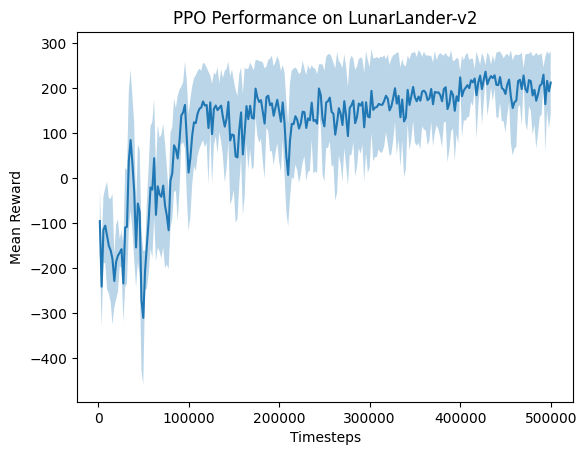

In [9]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('PPO Performance on LunarLander-v2')
matplotlib.pyplot.show()